# 📚 | Import Libraries

In [1]:
import pandas as pd
from pathlib import Path
import utils
import warnings

# ⚙️ | Utilities

In [2]:
# Created a utils module.
warnings.filterwarnings("ignore")

# 🗂️ | Data

The data includes the power supply of sites collected in different days. In more details, the data is divided into 3 datasets:

- **Site basic information and grid outage:** This dataset includes configuration parameters such as diesel output power (in kW) and battery capacity. It also covers grid-related parameters, including output power (in kW) and planned outages.
- **Solar power statistics:** Contains hourly data that details weather conditions (e.g., Direct Normal Irradiance (DNI), Diffuse Horizontal Irradiance (DHI), and Global Horizontal Irradiance (GHI)) along with the energy output measured in kilowatt-hours (kWh).
- **Energy consumption statistics:** Provides hour-by-hour energy consumption details, such as the total energy used by the base stations.

In [3]:
base_path = Path('data')
train_data_path = base_path/"trainData"
utils.print_folder_tree(base_path)

├── .DS_Store
├── SampleSubmission.csv
├── errorMetric_ex.py
├── manifest-981b91805c97d8bd0cdd65cf8d695b0d20240822-7912-1knfaac.json
└── trainData
    ├── energy consumption.csv
    ├── site information and grid outage.csv
    └── solar power and weather condition.csv


### Site basic information and grid outage

In [4]:
site_information = utils.clean_column_names(pd.read_csv(train_data_path/'site information and grid outage.csv'))
site_information.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   site_id                        10 non-null     object 
 1   diesel_powerkw                 10 non-null     float64
 2   battery_capacity_ah            10 non-null     int64  
 3   rated_voltagev                 10 non-null     int64  
 4   battery_charge_coefficient     10 non-null     float64
 5   battery_discharge_coefficient  10 non-null     float64
 6   init_soc                       10 non-null     float64
 7   dod                            10 non-null     float64
 8   grid_powerkw                   10 non-null     int64  
 9   grid_outage_plan               10 non-null     object 
dtypes: float64(5), int64(3), object(2)
memory usage: 932.0+ bytes


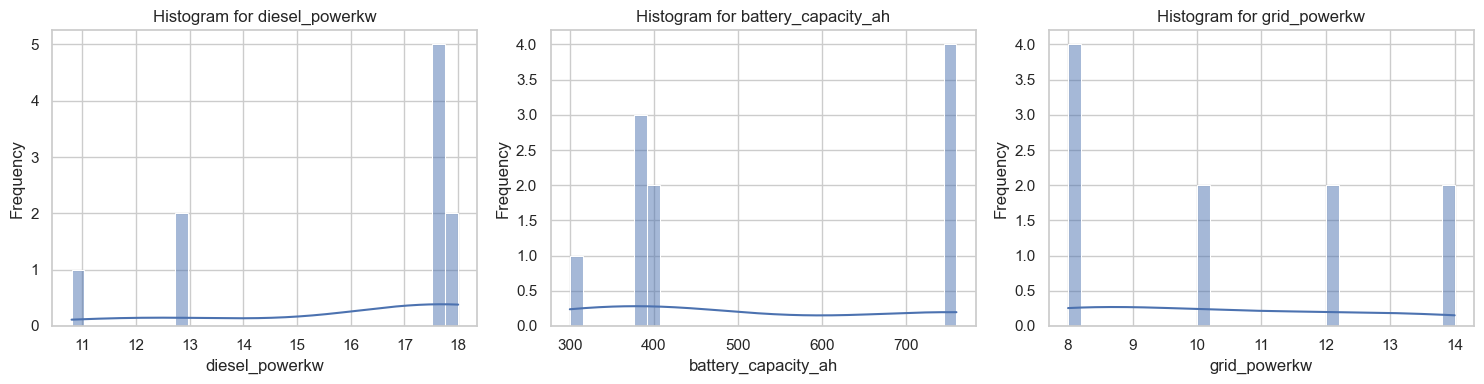

In [5]:
# Plot of distributions for numeric
utils.plot_histograms(site_information)

In [6]:
# utils.plot_boxplot(site_information, variables=['diesel_powerkw',
#        'battery_charge_coefficient', 'battery_discharge_coefficient',
#        'init_soc', 'dod', 'grid_powerkw', 'grid_outage_plan'], figsize=(12, 5))

### Solar power statistics

In [7]:
solar_power_statistics = utils.clean_column_names(pd.read_csv(train_data_path/"solar power and weather condition.csv"))

In [8]:
solar_power_statistics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14400 entries, 0 to 14399
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   site_name           14400 non-null  object 
 1   day                 14400 non-null  int64  
 2   hour                14400 non-null  int64  
 3   solar_zenith_angle  14400 non-null  float64
 4   clearsky_dhi        14400 non-null  float64
 5   clearsky_dni        14400 non-null  float64
 6   clearsky_ghi        14400 non-null  float64
 7   relative_humidity   14400 non-null  float64
 8   dhi                 14400 non-null  float64
 9   dni                 14400 non-null  float64
 10  ghi                 14400 non-null  float64
 11  energy_outputkwh    14400 non-null  float64
dtypes: float64(9), int64(2), object(1)
memory usage: 1.3+ MB


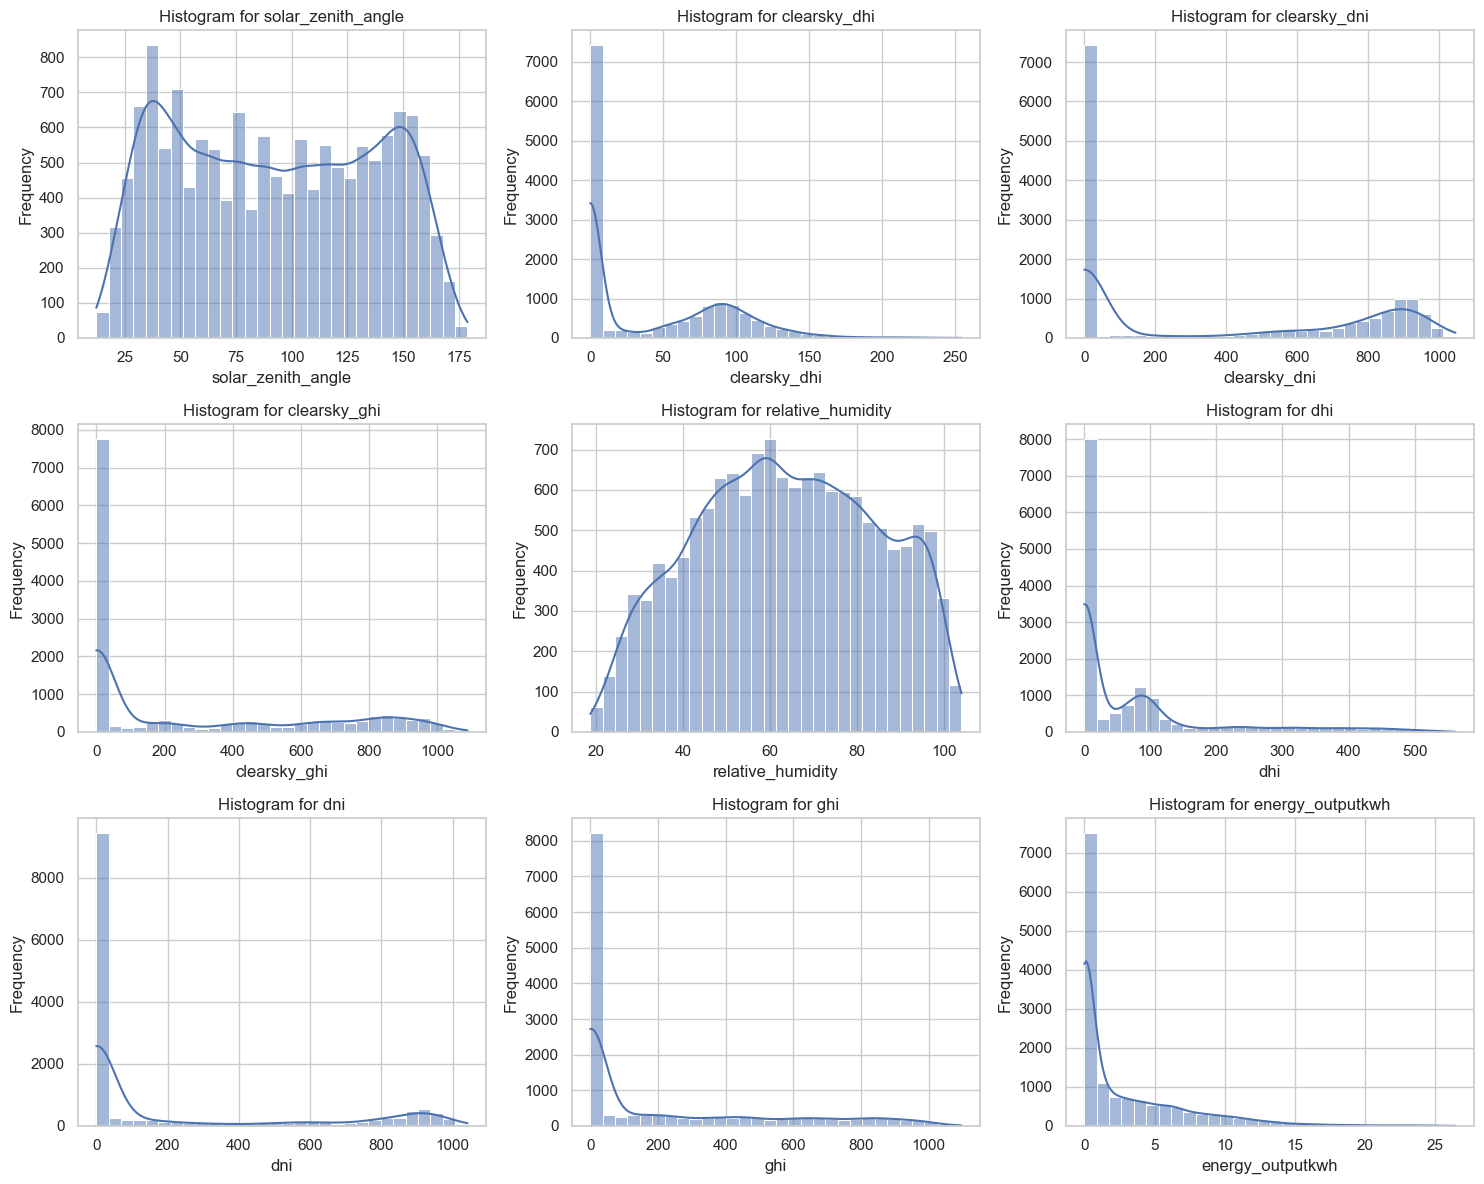

In [9]:
utils.plot_histograms(solar_power_statistics, skip_columns=['day', 'hour'])

In [10]:
# How many unique days? ->Two months of data.
solar_power_statistics['day'].nunique()

60

In [11]:
# And the days?
solar_power_statistics['hour'].nunique()

24

How many unique days?  
Two months of data, 24 hours a day.

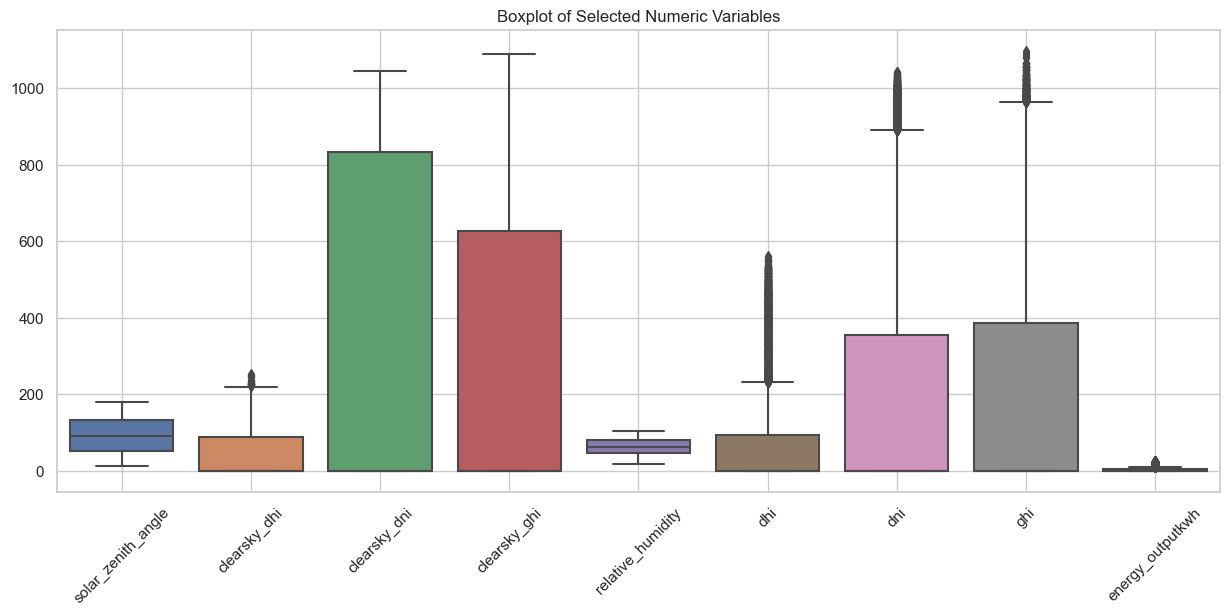

In [12]:
utils.plot_boxplot(solar_power_statistics, variables=['solar_zenith_angle', 'clearsky_dhi',
       'clearsky_dni', 'clearsky_ghi', 'relative_humidity', 'dhi', 'dni',
       'ghi', 'energy_outputkwh'], figsize=(15, 6))

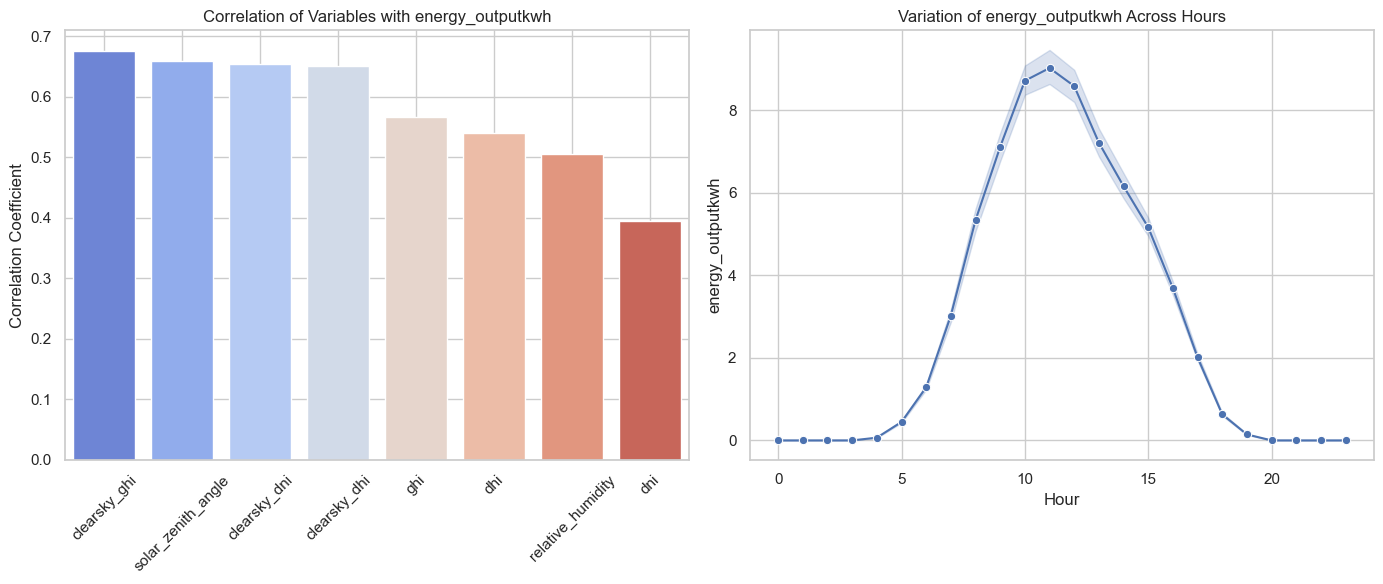

In [13]:
utils.plot_correlation_and_hour_variation(solar_power_statistics)

- the clear sky affects the energy the most as expected and the hours of the day as expected.

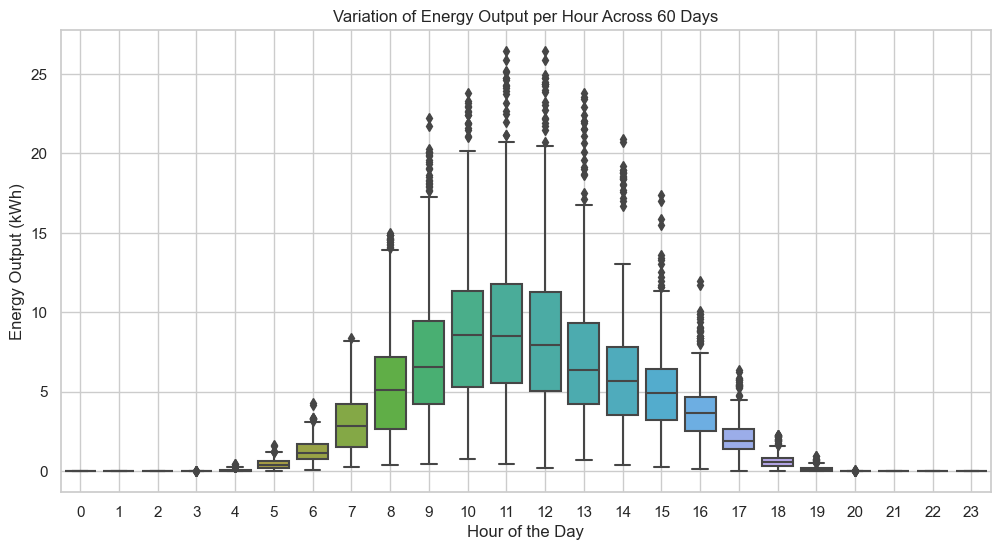

In [14]:
utils.plot_hourly_energy_variation(solar_power_statistics)

### Time Series Visualization
Plot the time series data and try to identify:
- any patterns
- and peak hours
- and any other learnings

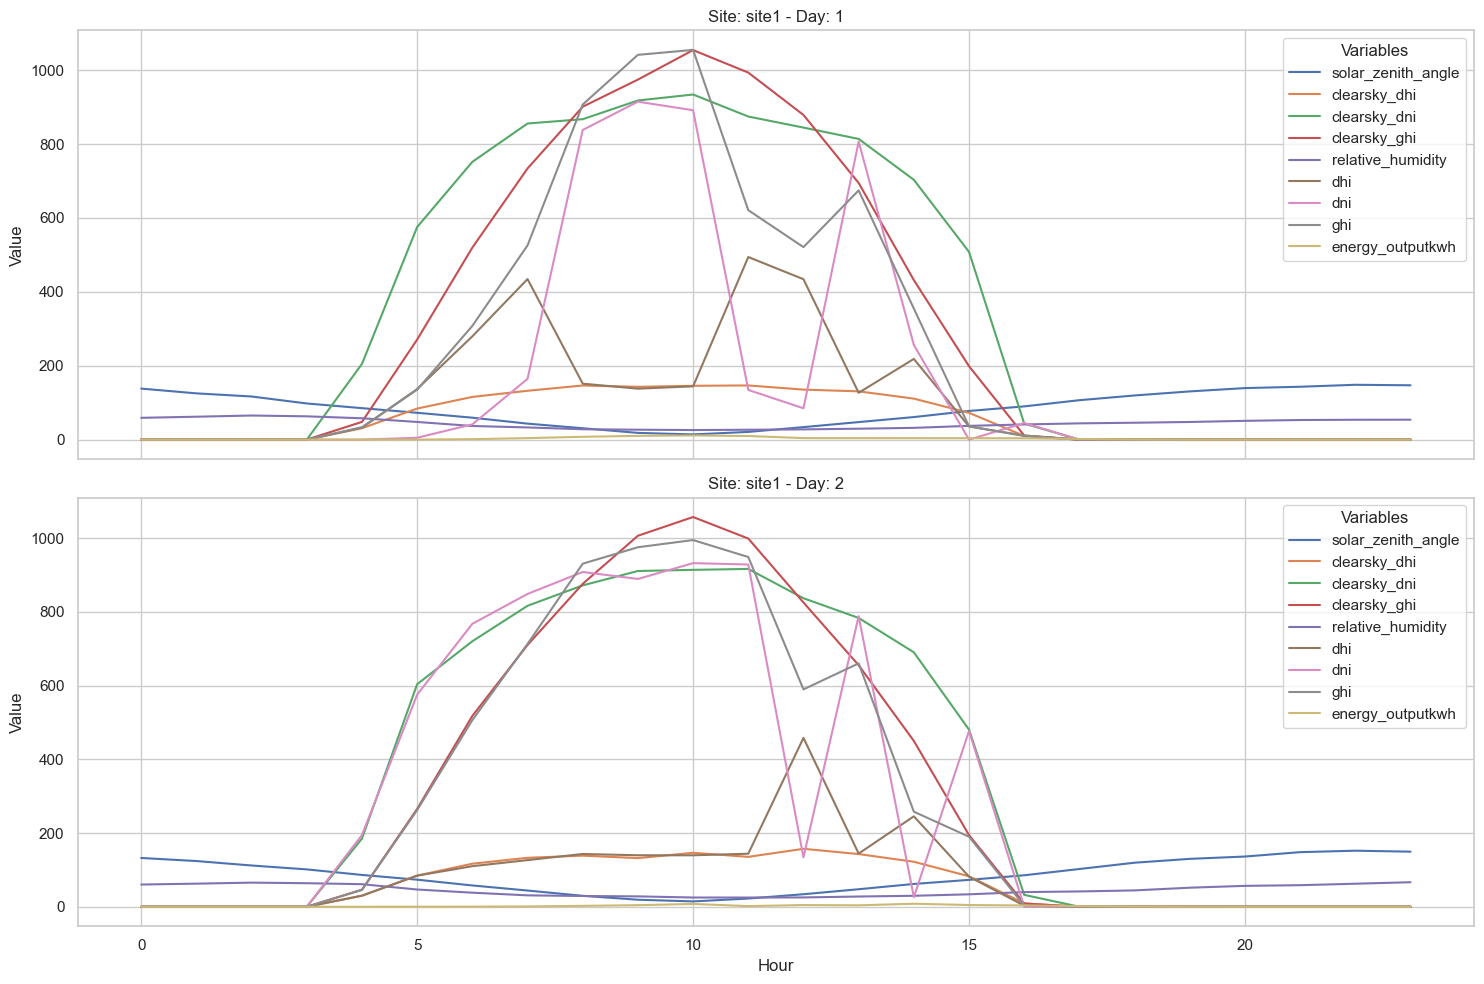

In [15]:
utils.plot_site_variables(
    site_name='site1', 
    site_data=solar_power_statistics, 
    days=list(range(1,3)),
    figsize=(15, 5),
    n_cols=1
)

In [16]:
# solar_power_statistics.columns

In [17]:
# not sure about the solar stats??

### Energy Consumption
Provides hour-by-hour energy consumption details, such as the total energy used by the base stations.

In [18]:
energy_consumption = utils.clean_column_names(pd.read_csv(train_data_path/"energy consumption.csv"))

In [19]:
energy_consumption.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14400 entries, 0 to 14399
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   site_name        14400 non-null  object 
 1   day              14400 non-null  int64  
 2   hour             14400 non-null  int64  
 3   total_energykwh  14400 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 450.1+ KB


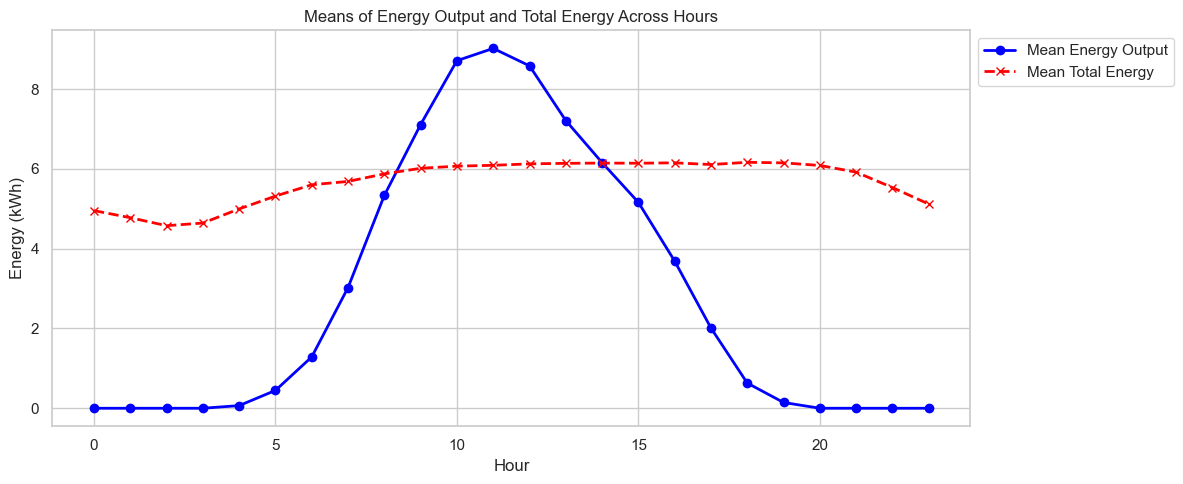

In [20]:
utils.plot_means(energy_consumption, solar_power_statistics, figsize=(12, 5))

## Questions
- ~what is the relationship between the energy output and solar power statistics?~
- ~what times of the day is the most power produced?~
    - the clear sky affects the energy the most as expected and the most energy is produced at midday.
- ~what is the relationship between the solar energy output and the energy consumption?~
    - the energy consumption is the same across the day regardless of solar output.
    - so what does solar do?
- what is the variation of the solar engery across the days in the data?
- why is the data given in a day format?
- what is the grid outage plan?
- what is the relationship between energy_outputkwh, total_energykwh and grid_outage_plan?
- what is the clear competition goal?

## Notes
- solar_zenith_angle, clearsky_dhi, relative_humidity, dhi are by magnitude smaller than the other variables, need for scaling preprocessing.